# Text Extraction

Author: Attila Zsíros, 2023


## Assignment

*"Hello, I am your new client and I need your help with my issue. I have thousands and
thousands of papers in the boxes back in my garage. The important part is that there is
always some number on each paper. Now I would like to somehow extract all these numbers
and for example store them somewhere, in a text file, Excel, it doesn't really matter. Can you
help me with that?"*

TLDR: *"I have a number printed on a paper and I want to read it."*

### Additional questions
 - Image acquisition method?
   - Scanner or phone?
 - Type of digits
   - Handwritten or machine printed?
 - Size of digits
   - Is it fixed?
 - One number per paper?
   - If multiple numbers possible, is there one you are specifically interested in?
 - Document content?
   - Is the number the only content of the document or does it contain also text or images?
 - Does the document layout have a fixed structure?
   - If yes, we can simplify the task by focusing on a ROI.

## Solution

My solution consists of two parts:
  1. Digit Localization
  2. Digit Classification

### Assumptions
 - Images are going to be obtained by a scanner, given the large quantity of papers.
   - This simplifies the image preprocessing.


In [24]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow import keras
from tensorflow.keras import layers
import os


%matplotlib inline

## Localization

### Load test dataset

In [16]:
DIR_PATH = "../dataset/"
img_paths = list(filter(lambda f: '.png' in f, os.listdir(DIR_PATH)))

imgs = [~cv2.imread(DIR_PATH + img_path, 0) for img_path in img_paths]

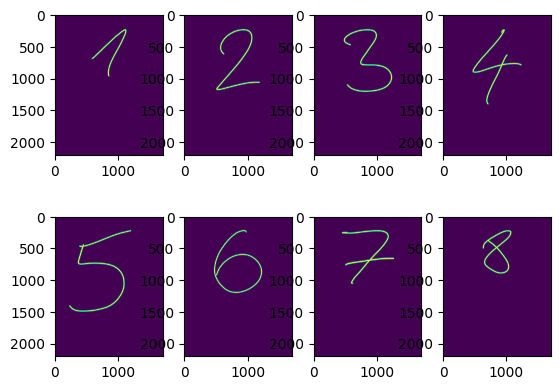

In [20]:
NCOLS = 4
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    
plt.show()

### Find Bounding Boxes

The Bounding Box is obtained from the contours of the digit.

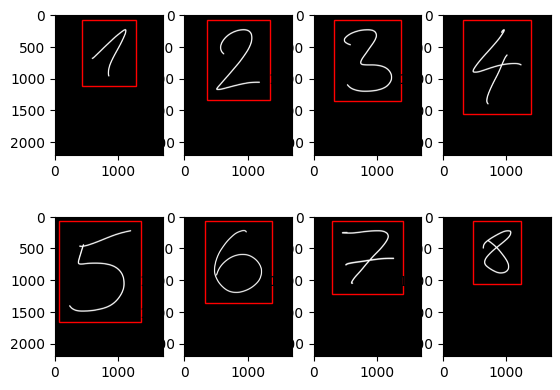

In [49]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

kernel = np.ones((3, 3), np.uint8)
digits = []
for i, img in enumerate(imgs):
	ax[i].imshow(img, cmap=plt.cm.gray)

	# dilate the numbers add margins to the bounding box
	img_dilated = cv2.dilate(img, kernel, iterations=150)
 
	# retrieves all of the contours without establishing any hierarchical relationships
	contours, _ = cv2.findContours(img_dilated, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
	x, y, w, h = cv2.boundingRect(contours[-1])
	ax[i].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
	digits.append(img[y:y+h, x:x+w])

plt.show()

### Extract ROIs

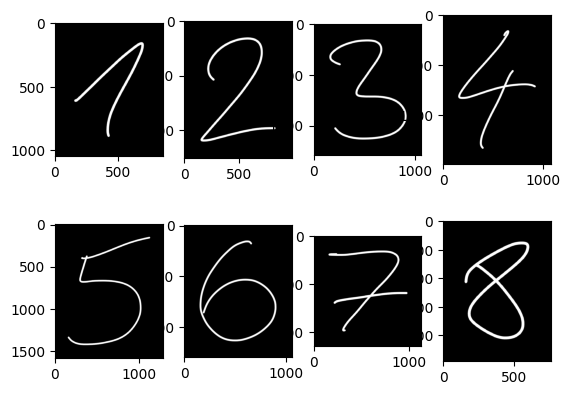

In [50]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

for i, digit in enumerate(digits):
    ax[i].imshow(digit, cmap=plt.cm.gray)
    
plt.show()

## Classification

For classification, we are going to use a CNN trained on the MNIST dataset. The CNN architecture and training is taken from https://keras.io/examples/vision/mnist_convnet/.

### Load MNIST

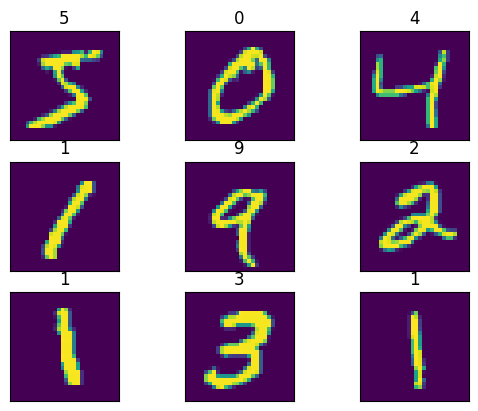

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [55]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

fig, ax = plt.subplots(3, 3)
ax = ax.flatten()
for i in range(9):
    ax[i].imshow(x_train[i])
    ax[i].title.set_text(y_train[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Design of the network

In [35]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

### Training

In [36]:
batch_size = 128
epochs = 3

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/3
422/422 [==============================] - 23s 54ms/step - loss: 0.3681 - accuracy: 0.8861 - val_loss: 0.0808 - val_accuracy: 0.9785
Epoch 2/3
422/422 [==============================] - 27s 63ms/step - loss: 0.1110 - accuracy: 0.9661 - val_loss: 0.0583 - val_accuracy: 0.9832
Epoch 3/3
422/422 [==============================] - 27s 64ms/step - loss: 0.0843 - accuracy: 0.9742 - val_loss: 0.0469 - val_accuracy: 0.9873


### MNIST Test evaluation

In [46]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03937013819813728
Test accuracy: 0.9872999787330627


### Test dataset evaluation

To feed our dataset into the network, we have to match its input dimensions to the MNIST dataset input dimensions, i.e., downsample our digits to 28x28 pixels.

1/1 [==============================] - 0s 18ms/step


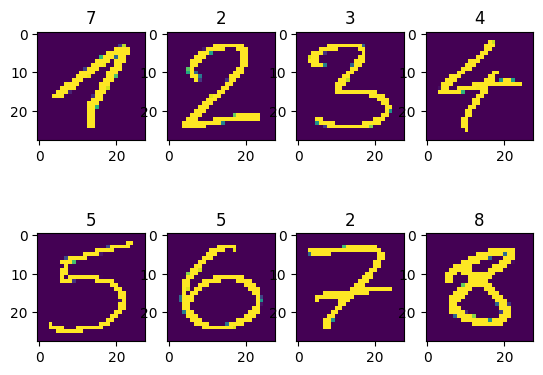

In [60]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

digits_rs = []
for i, digit in enumerate(digits):
    # dilate the digit lines to "survive" downsampling
    digit_rs = cv2.dilate(digit, kernel, iterations=20)
    # resize to 28x28
    digit_rs = cv2.resize(digit_rs, (28, 28), interpolation=cv2.INTER_CUBIC).astype(np.float32)/255
    
    # expand dimensions to create a batch
    digit_input = np.reshape(digit_rs, (1, 28, 28, 1))
    pred = model.predict(digit_input)
    
    ax[i].imshow(digit_rs)
    ax[i].title.set_text(np.argmax(pred))

plt.show()

As we can see, the network classified 5 out of 8 handwritten digits correctly.

## Conclusion

 - The presented solution is neither perfect, nor particularly robust.
   - For localization, we could also use deep learning approaches, such as Mask R-CNN or YOLO.
   - The classification accuracy could be improved by additional training of the network with different digit datasets.
   